In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
from PIL import Image
import io
import matplotlib.pyplot as plt
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Hayvan listesi
animal_classes = [
    "antelope", "badger", "bat", "bear", "bee", "beetle", "bison", "boar", "butterfly", "cat",
    "caterpillar", "chimpanzee", "cockroach", "cow", "coyote", "crab", "crow", "deer", "dog", "dolphin",
    "donkey", "dragonfly", "duck", "eagle", "elephant", "flamingo", "fly", "fox", "goat", "goldfish",
    "goose", "gorilla", "grasshopper", "hamster", "hare", "hedgehog", "hippopotamus", "hornbill", "horse", "hummingbird",
    "hyena", "jellyfish", "kangaroo", "koala", "ladybugs", "leopard", "lion", "lizard", "lobster", "mosquito",
    "moth", "mouse", "octopus", "okapi", "orangutan", "otter", "owl", "ox", "oyster", "panda",
    "parrot", "pelecaniformes", "penguin", "pig", "pigeon", "porcupine", "possum", "raccoon", "rat", "reindeer",
    "rhinoceros", "sandpiper", "seahorse", "seal", "shark", "sheep", "snake", "sparrow", "squid", "squirrel",
    "starfish", "swan", "tiger", "turkey", "turtle", "whale", "wolf", "wombat", "woodpecker", "zebra"
]

# Görüntüleri yüklemek için dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root_dir, transform=transform)
        self.classes = self.data.classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Ön işleme ve augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Lütfen data.zip dosyasını yükleyin:")
uploaded = files.upload()

import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Veri setini yükleme
dataset = CustomImageDataset(root_dir='/content/data/train', transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Lütfen data.zip dosyasını yükleyin:


Saving data.zip to data.zip


In [4]:
# Swin Transformer Tiny'yi yükleme
model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, len(dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 171MB/s] 


In [5]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Eğitim
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Doğrulama
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Erken durdurma
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Son modeli al
torch.save(model.state_dict(), 'final_model.pth')

Epoch 1/10, Train Loss: 2.7689, Train Acc: 0.4560, Val Loss: 0.6667, Val Acc: 0.8480, Precision: 0.8833, Recall: 0.8480, F1: 0.8478
Epoch 2/10, Train Loss: 0.5500, Train Acc: 0.8947, Val Loss: 0.3424, Val Acc: 0.8952, Precision: 0.9156, Recall: 0.8952, F1: 0.8969
Epoch 3/10, Train Loss: 0.2797, Train Acc: 0.9552, Val Loss: 0.2837, Val Acc: 0.9214, Precision: 0.9317, Recall: 0.9214, F1: 0.9209
Epoch 4/10, Train Loss: 0.1714, Train Acc: 0.9722, Val Loss: 0.2397, Val Acc: 0.9298, Precision: 0.9365, Recall: 0.9298, F1: 0.9300
Epoch 5/10, Train Loss: 0.1369, Train Acc: 0.9796, Val Loss: 0.2205, Val Acc: 0.9329, Precision: 0.9421, Recall: 0.9329, F1: 0.9325
Epoch 6/10, Train Loss: 0.0951, Train Acc: 0.9877, Val Loss: 0.2236, Val Acc: 0.9371, Precision: 0.9438, Recall: 0.9371, F1: 0.9373
Epoch 7/10, Train Loss: 0.0814, Train Acc: 0.9887, Val Loss: 0.2042, Val Acc: 0.9434, Precision: 0.9482, Recall: 0.9434, F1: 0.9432
Epoch 8/10, Train Loss: 0.0736, Train Acc: 0.9906, Val Loss: 0.2423, Val Acc

Lütfen bir test resmi yükleyin:


Saving Black-And-Gold-Lion-King-Animal-Tempered-Glass-Wall-Art-90cm-2.jpg to Black-And-Gold-Lion-King-Animal-Tempered-Glass-Wall-Art-90cm-2.jpg
Saving a21054_1000x1000s_lion_soft_toy_1.jpg to a21054_1000x1000s_lion_soft_toy_1.jpg
Saving Website_SpeciesPage_Lion03_02_Solutions.jpg to Website_SpeciesPage_Lion03_02_Solutions.jpg
Saving VIER_20PFOTEN_2012-05-15_002_20(1)-1927x1333-1920x1328.jpg to VIER_20PFOTEN_2012-05-15_002_20(1)-1927x1333-1920x1328.jpg
Tahmin: lion, Güven Skoru: 99.34%


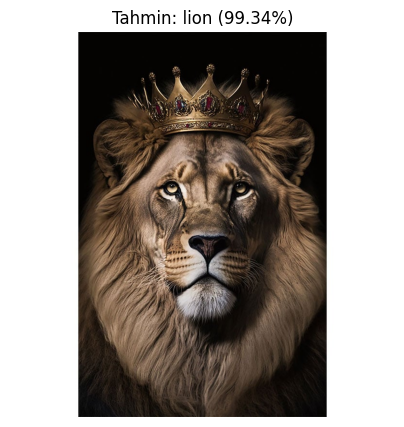

Tahmin: dog, Güven Skoru: 27.62%


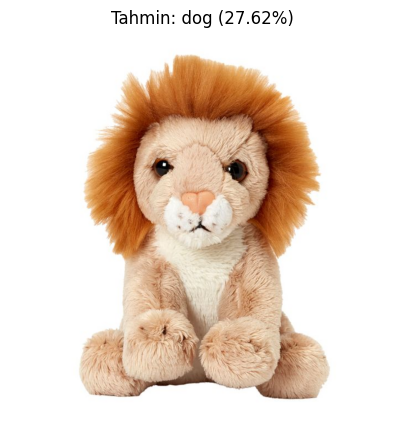

Tahmin: lion, Güven Skoru: 99.93%


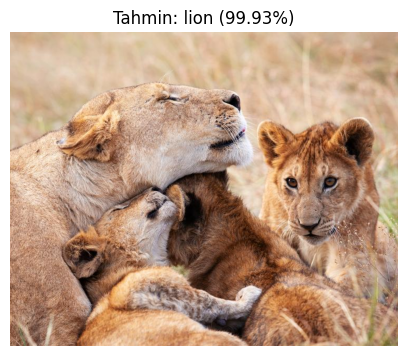

Tahmin: lion, Güven Skoru: 99.99%


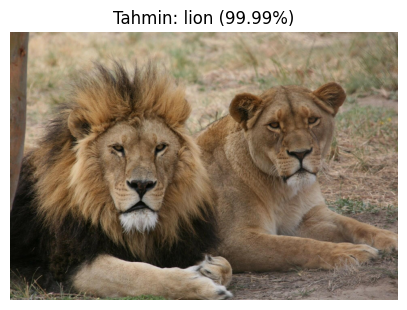

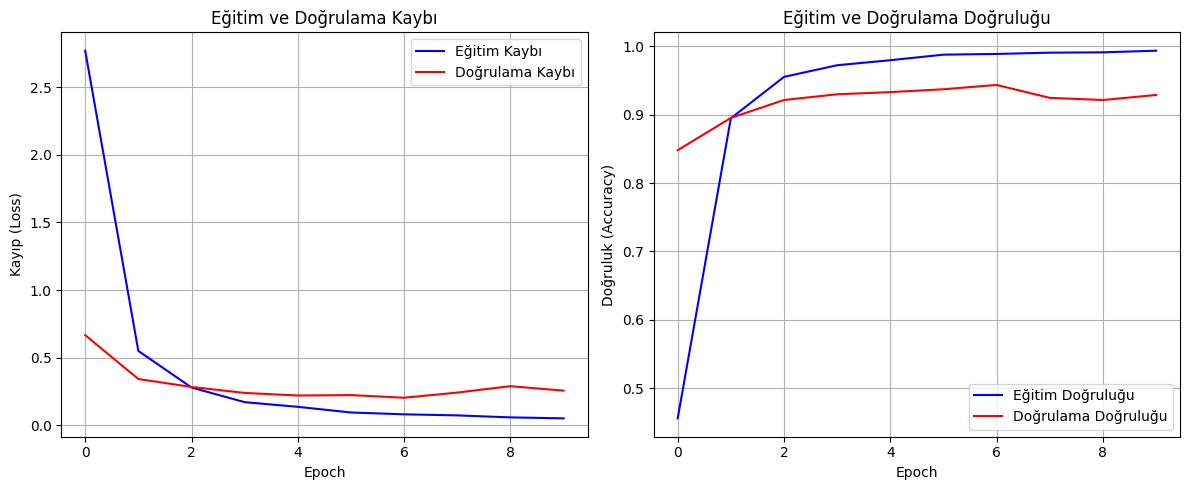

In [13]:
def predict_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        confidence = torch.softmax(outputs, dim=1)[0][predicted].item() * 100
    return animal_classes[predicted.item()], confidence

print("Lütfen bir test resmi yükleyin:")
uploaded = files.upload()
for fn in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
    animal, confidence = predict_image(image)
    print(f"Tahmin: {animal}, Güven Skoru: {confidence:.2f}%")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Tahmin: {animal} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Öğrenme eğrileri (train_losses, val_losses, train_accs, val_accs)
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim Kaybı', color='blue')
plt.plot(val_losses, label='Doğrulama Kaybı', color='red')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.grid(True)

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Eğitim Doğruluğu', color='blue')
plt.plot(val_accs, label='Doğrulama Doğruluğu', color='red')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()